In [238]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import tensorboard
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers

In [239]:
tfd = tfp.distributions
encoded_size = 1
input_shape =(1,)
nbparamsl = 2
nbparamsobs = 2


In [240]:
A = tfd.Gamma(concentration = 3.0, rate=0.5).sample(1000)
X = tfd.InverseGamma(concentration =2.5, scale = 0.6 ).sample(1000)
Y=A*X
train_dataset = Y[:750]
train_dataset = tf.reshape(train_dataset,[750,1])
eval_dataset = Y[750:]
eval_dataset=tf.reshape(eval_dataset,[250,1])
print(eval_dataset)

tf.Tensor(
[[ 4.166064  ]
 [ 2.0617237 ]
 [ 0.7975022 ]
 [ 3.0150936 ]
 [ 1.2456452 ]
 [ 0.24297418]
 [ 0.29549652]
 [ 0.96418023]
 [ 1.6970513 ]
 [ 0.21662833]
 [ 0.71700716]
 [ 1.0329157 ]
 [ 1.4748023 ]
 [ 1.433009  ]
 [ 3.1025934 ]
 [ 0.12778206]
 [ 1.2576612 ]
 [ 3.191077  ]
 [ 2.2670956 ]
 [ 0.6864456 ]
 [ 2.3519783 ]
 [ 1.5782658 ]
 [ 1.000204  ]
 [ 1.0360786 ]
 [ 1.0044599 ]
 [ 0.15568787]
 [ 6.9156733 ]
 [ 3.9821098 ]
 [ 2.0989177 ]
 [ 2.3507297 ]
 [ 0.31857738]
 [ 7.2617774 ]
 [ 1.8392973 ]
 [ 0.59743583]
 [ 0.47848764]
 [ 3.638822  ]
 [ 3.0592825 ]
 [ 3.7768977 ]
 [ 1.1049676 ]
 [ 2.0419924 ]
 [10.034045  ]
 [ 2.8299484 ]
 [ 3.727061  ]
 [ 0.20720495]
 [ 0.14140378]
 [22.814379  ]
 [ 2.3120887 ]
 [ 0.7162351 ]
 [ 2.408512  ]
 [ 1.2595661 ]
 [ 5.5502977 ]
 [ 1.9007784 ]
 [ 2.9864144 ]
 [ 2.9795945 ]
 [ 4.5330434 ]
 [ 2.5345273 ]
 [ 1.2749332 ]
 [ 0.9283732 ]
 [ 1.5014138 ]
 [ 1.893081  ]
 [ 9.818215  ]
 [ 1.0866961 ]
 [ 3.0814228 ]
 [ 0.33195835]
 [ 1.7956934 ]
 [ 1.8703866 ]

/anaconda/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


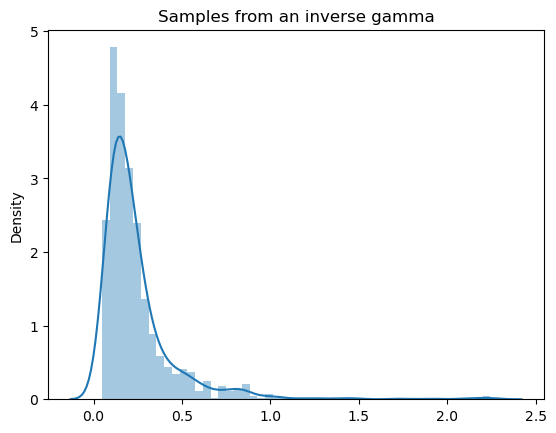

In [241]:
import inspect
#inspect.getargspec(tfd.InverseGamma)
invG = tfd.InverseGamma(concentration = 3, scale =0.5)
samples = invG.sample(1000)

sns.distplot(samples)
plt.title("Samples from an inverse gamma")
plt.show()
prior = invG

In [242]:
tfpl = tfp.layers
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=(1,)),
    tfkl.Dense(2,activation='relu', use_bias = True),
    tfkl.Dense(1,
               activation=None),
    tfkl.Flatten(),
    tfkl.Lambda(lambda x: x ** 2+0.001),
    tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.InverseGamma(
        concentration=t, scale=t),
    convert_to_tensor_fn=lambda s: s.sample(1),
    activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

In [243]:
Input_test= tf.constant([2.0])
print(Input_test)

print(encoder(Input_test))
model_encoder = tfk.Model(inputs=encoder.inputs,
                outputs=encoder.outputs)
print(model_encoder.output_shape)

tf.Tensor([2.], shape=(1,), dtype=float32)
tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1, 1], event_shape=[], dtype=float32)
(1, None, 1)


In [244]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Dense(2,activation='relu', use_bias = True),
    tfkl.Dense(nbparamsobs,
               activation=None),
    tfkl.Flatten(),
    tfkl.Lambda(lambda x: x ** 2+0.001),
    tfpl.DistributionLambda(
    make_distribution_fn=lambda v: tfd.Gamma(
        concentration=v, rate=v)),
 #   convert_to_tensor_fn=lambda s: s.sample),
])

In [245]:
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))
print(vae.output_shape)

(1, None)


In [246]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

In [247]:
vae.fit(train_dataset,train_dataset,batch_size=1,
        epochs=15)


Epoch 1/15
750/750 [==============================] - 3s 2ms/step - loss: nan
Epoch 2/15
750/750 [==============================] - 2s 2ms/step - loss: nan
Epoch 3/15
750/750 [==============================] - 2s 3ms/step - loss: nan
Epoch 4/15
750/750 [==============================] - 2s 2ms/step - loss: nan
Epoch 5/15
750/750 [==============================] - 2s 2ms/step - loss: nan
Epoch 6/15
750/750 [==============================] - 2s 2ms/step - loss: nan
Epoch 7/15
750/750 [==============================] - 2s 3ms/step - loss: nan
Epoch 8/15
750/750 [==============================] - 2s 2ms/step - loss: nan
Epoch 9/15
750/750 [==============================] - 2s 3ms/step - loss: nan
Epoch 10/15
750/750 [==============================] - 2s 2ms/step - loss: nan
Epoch 11/15
750/750 [==============================] - 2s 3ms/step - loss: nan
Epoch 12/15
750/750 [==============================] - 2s 2ms/step - loss: nan
Epoch 13/15
750/750 [==============================] - 2s 2ms

In [153]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255


In [155]:
print(x_train.shape)

(60000, 784)
